### 一.朴素贝叶斯分类器简介
朴素贝叶斯模型（Naive Bayes）中的“朴素”就在于它的条件独立性假设：   

$$
p(X_1,X_2,...,X_n\mid Y)=p(X_1\mid Y)\cdot p(X_2\mid Y)\cdots p(X_n\mid Y)
$$  

用概率图表示如下：  
![avatar](./source/12_朴素贝叶斯概率图.png)
所以它的联合概率分布：   

$$
p(X_1,X_2,...,X_n,Y)=p(Y)\prod_{i=1}^np(X_i\mid Y)
$$  

所以，朴素贝叶斯分类器可以定义如下：   

$$
f(x)=arg\max_{c_k}P(Y=c_k)\prod_{i=1}^nP(X_i=x_i\mid Y=c_k)
$$  

这里$c_k(k=1,2,...,K)$表示分类器所属的类别

### 二.参数估计
对于朴素贝叶斯中参数$p(Y=c_k)$以及$p(X_i=x_i\mid Y=c_k)$可以通过极大似然估计来学习，下面直接写估计结果

#### 1.求解$p(Y=c_k)$

$$
p(Y=c_k)=\frac{\sum_{i=1}^NI(y_i=c_k)}{N},k=1,2,...,K,N表示样本量
$$

#### 2.求解$p(X_i=x_i\mid Y=c_k)$
假设第$i$个特征可能的取值为$A_i=\{a_{i1},a_{i2},...,a_{iS_i}\}$，所以有$x_i=a_{il}\in A_i$，所以：   

$$
p(X_i=x_i\mid Y=c_k)=p(X_i=a_{il}\mid Y=c_k)=\frac{\sum_{j=1}^NI(x_i^j=a_{il},y_i=c_k)}{\sum_{i=1}^nI(y_j=c_k)}
$$

### 三.代码实现

In [1]:
import os
os.chdir('../')
import numpy as np
from ml_models import utils
from ml_models.wrapper_models import DataBinWrapper
%matplotlib inline

"""
朴素贝叶斯分类器实现，封装到ml_models.pgm
"""

class NaiveBayesClassifier(object):
    def __init__(self, max_bins=10):
        """
        :param max_bins:为了方便，对x每维特征做分箱
        """
        self.dbw = DataBinWrapper(max_bins=max_bins)
        # 记录模型参数
        self.default_y_prob = None  # y的默认概率
        self.default_x_prob = {}  # x的默认概率
        self.p_y = {}  # p(y)
        self.p_x_y = {}  # p(x | y)
        self.class_num = None

    def fit(self, x, y):
        self.default_y_prob = np.log(0.5 / (y.max()+1))
        # 分箱
        self.dbw.fit(x)
        x_bins = self.dbw.transform(x)
        # 参数估计
        self.class_num = y.max() + 1
        for y_index in range(0, self.class_num):
            # p(y)
            y_n_sample = np.sum(y == y_index)
            self.default_x_prob[y_index] = np.log(0.5 / y_n_sample)
            x_y = x_bins[y == y_index]
            self.p_y[y_index] = np.log(y_n_sample / (self.class_num + len(y)))
            self.p_x_y[y_index] = {}
            # p(x | y)
            for i in range(0, x_y.shape[1]):
                self.p_x_y[y_index][i] = {}
                x_i_feature_set = set(x_y[:, i])
                for x_feature in x_i_feature_set:
                    self.p_x_y[y_index][i][x_feature] = np.log(
                        np.sum(x_y[:, i] == x_feature) / (y_n_sample + len(x_i_feature_set)))

    def predict_proba(self, x):
        x_bins = self.dbw.transform(x)
        rst = []
        for x_row in x_bins:
            tmp = []
            for y_index in range(0, self.class_num):
                try:
                    p_y_log = self.p_y[y_index]
                except:
                    p_y_log = self.default_y_prob
                for i,xij in enumerate(x_row):
                    try:
                        p_y_log += self.p_x_y[y_index][i][xij]
                    except:
                        p_y_log += self.default_x_prob[y_index]
                tmp.append(p_y_log)
            rst.append(tmp)
        return utils.softmax(np.asarray(rst))

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [2]:
#造伪数据
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.85, random_state=0)
X = X[:, ::-1]

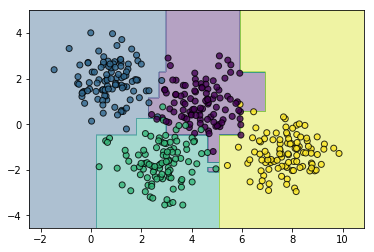

In [3]:
#查看效果
nb = NaiveBayesClassifier(max_bins=20)
nb.fit(X, y)
utils.plot_decision_function(X, y, nb)

由于对连续值做了分箱处理，导致边界处的样本点划分不够细腻，处理这种情况，我们可以将每一类样本的每一维特征视作从某一一维高斯分布抽样而来，则便是gaussian naive bayes

### 四.Gaussian NB
我们可以假设$p(X_i\mid Y=c_k)$来源于一个一维的高斯分布：   

$$
p(x_i\mid y=c_k)=\frac{1}{\sqrt{2\pi}\cdot\sigma_{k,i}}exp(-\frac{(x_i-u_{k,i})^2}{2\sigma_{k,i}^2})
$$  

$u_{k,i},\sigma_{k,i}$分别表示第$k$个类别在第$i$个特征上的高斯分布的均值和标准差，而对高斯分布的参数做极大似然估计也非常好计算，$u,\sigma$即是对应样本的所在特征集合的均值和标准差（求解过程可在EM那一章找到），接下来对上面的代码略作调整即可

In [4]:
"""
高斯朴素贝叶斯分类器实现，封装到ml_models.pgm
"""

class GaussianNBClassifier(object):
    def __init__(self):
        self.p_y = {}  # p(y)
        self.p_x_y = {}  # p(x | y)
        self.class_num = None

    def fit(self, x, y):
        # 参数估计
        self.class_num = y.max() + 1
        for y_index in range(0, self.class_num):
            # p(y)
            y_n_sample = np.sum(y == y_index)
            self.p_y[y_index] = np.log(y_n_sample / len(y))
            self.p_x_y[y_index] = {}
            # p(x | y)
            x_y = x[y == y_index]
            for i in range(0, x_y.shape[1]):
                u = np.mean(x_y[:, i])
                sigma = np.std(x_y[:, i])
                self.p_x_y[y_index][i] = [u, sigma]

    def predict_proba(self, x):
        rst = []
        for x_row in x:
            tmp = []
            for y_index in range(0, self.class_num):
                p_y_log = self.p_y[y_index]
                for j in range(0, len(x_row)):
                    xij = x_row[j]
                    p_y_log += np.log(utils.gaussian_1d(xij, self.p_x_y[y_index][j][0], self.p_x_y[y_index][j][1]))
                tmp.append(p_y_log)
            rst.append(tmp)
        return utils.softmax(np.asarray(rst))

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

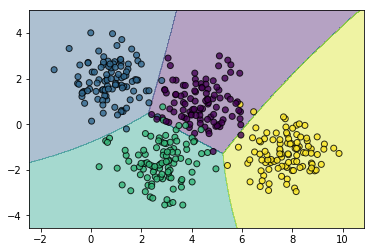

In [5]:
#查看效果
gnb = GaussianNBClassifier()
gnb.fit(X, y)
utils.plot_decision_function(X, y, gnb)

哟，这结果不是和上一章EM中的GMM分类器效果差不多（仔细看，会有一点点小差异），只是EM中是使用的二维高斯分布，而这里是使用的二个一维高斯分布，其实当特征间条件独立时，满足如下的关系：   

$$
N(x_1,x_2\mid \theta)=N_1(x_1\mid \theta_1)N_2(x_2\mid \theta_2)
$$  

即一个高维高斯的概率分布可以直接拆为多个一维高斯概率分布的乘积，具体证明可以参看这篇[博客>>>](https://www.cnblogs.com/jermmyhsu/p/8251013.html)，不想码公式了~~~